## Week 5: Classification metrics

In this tutorial, we will learn the different metric for classification models that can be used. The dataset we will be using  contains records of simulation crashes encountered during climate model uncertainty quantification (UQ) ensembles. You can read more about the dataset <a href=https://archive.ics.uci.edu/ml/datasets/Climate+Model+Simulation+Crashes>here</a>

#### Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Load Dataset

In [2]:
# Since the dataset contains multiple spaces between the columns, use \s+ for sep parameter
df = pd.read_csv('climate_simulation.dat', sep='\s+')
df.head()

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


In [3]:
# check for null values
df.isnull().sum()

Study                   0
Run                     0
vconst_corr             0
vconst_2                0
vconst_3                0
vconst_4                0
vconst_5                0
vconst_7                0
ah_corr                 0
ah_bolus                0
slm_corr                0
efficiency_factor       0
tidal_mix_max           0
vertical_decay_scale    0
convect_corr            0
bckgrnd_vdc1            0
bckgrnd_vdc_ban         0
bckgrnd_vdc_eq          0
bckgrnd_vdc_psim        0
Prandtl                 0
outcome                 0
dtype: int64

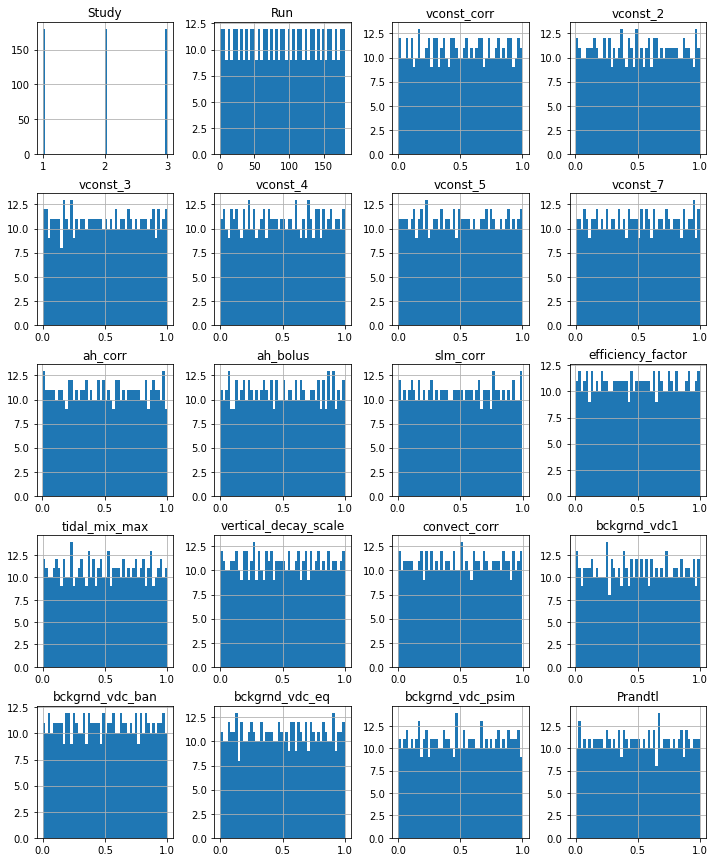

In [4]:
# drop the target variable and # create a histogram plot of each numeric variable
ax = df.drop(columns=['outcome']).hist(bins=50, figsize=(12, 15))
# show the plot
plt.show()

Based on the analysis, we know that the data contains no null values. Study and Run can be removed, then we can say that all the model input attributes are scaled. 

In [5]:
# Converting the outcome variable to report failed - this is done to evaluate the model's performance later 
# using multiple scores in cross_validation as currently there's no way to change pos_label when we perform cross validation
df['outcome'] = 1 - df['outcome']
df.rename(columns={'outcome': 'failed'}, inplace=True)

In [6]:
X = df.drop(columns=['Study', 'Run', 'failed'])
y = df[['failed']]

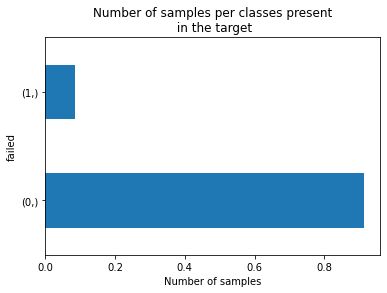

In [7]:
y.value_counts(normalize=True).plot.barh()
plt.xlabel("Number of samples")
plt.title("Number of samples per classes present\n in the target");

We can see that the vector `y` contains two classes corresponding to whether a simulation run failed or not. We will use a desicion tree classifier to predict this outcome.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [9]:
classifier = DecisionTreeClassifier(random_state=5)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=5)

In [10]:
y_predicted = classifier.predict(X_test)
y_predicted[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [11]:
accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.926


### Confusion matrix and derived metrics

The accuracy that we calculated did not take into account the type of error our classifier was making. Accuracy is an aggregate of the errors made by the classifier. We may be interested in finer granularity - to know independently what the error is for each of the two following cases:

- we predicted that a simulation failed but it did not;      
- we predicted that a simulation did not fail but it did.

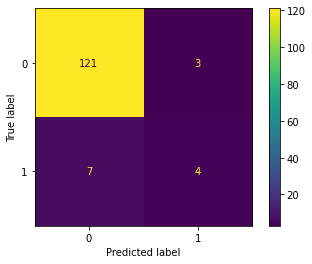

In [12]:
# plot_confusion_matrix(classifier, X_test, y_test);
cm = confusion_matrix(y_test, y_predicted, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot();

The in-diagonal numbers are related to predictions that were correct while off-diagonal numbers are related to incorrect predictions (misclassifications). Precision and recall are two metrics to assess the correctness of the classifications in different settings. scikit-learn provides functions to compute these statistics.

In [13]:
# Since we are interested in determining the scenario when the simulation failed, pos_label should be 1
precision = precision_score(y_test, y_predicted, pos_label=1)
recall = recall_score(y_test, y_predicted, pos_label=1)

print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.571
Recall score: 0.364


### The issue of class imbalance

The accuracy looked great (i.e. >90%) but precision and recall are very low. We did see earlier that the number of records of simulation failed class denoted as `1` constitutes <10% of the whole dataset. Thus, the good accuracy of our classifier is then linked to its ability to correctly predict the simulation success class denoted as `0` which may or may not be relevant, depending on the application. We can illustrate the issue using a dummy classifier as a baseline.

In [14]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
print(f"Accuracy of the dummy classifier: " f"{dummy_classifier.score(X_test, y_test):.3f}")

Accuracy of the dummy classifier: 0.919


With the dummy classifier, which always predicts the positive class of simulation success, we obtain an accuracy score of 91.9%. Therefore, it means that this classifier, without learning anything from the data, is capable of predicting almost as accurately as our Decision Tree classifier model. Therefore, we can use the precision, recall or balanced accuracy score instead of accuracy.

In [15]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(y_test, y_predicted)
print(f"Balanced accuracy: {balanced_accuracy:.3f}")

Balanced accuracy: 0.670


The balanced accuracy is equivalent to accuracy in the context of balanced classes.

### ROC-Curve

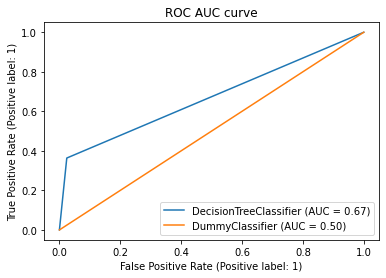

In [16]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test, pos_label=1)
disp = RocCurveDisplay.from_estimator(dummy_classifier, X_test, y_test, pos_label=1, ax = disp.ax_)
disp.ax_.set_title("ROC AUC curve");

It is important to observe that the lower bound of the ROC-AUC is 0.5. Indeed, we show the generalization performance of a dummy classifier (the orange line) to show that even the worst generalization performance obtained will be above this line.

### Cross Validation

While we have been splitting the data as train-test sets, we might have gotten (un)lucky with the way the data is split. So, using cross-validation we can be sure that the result of the evaluation metric used to assess the model's performance is not by chance.  In scikit-learn, we can perform cross validation in two ways: 
- <a href=https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html>cross_val_score </a>
- <a href=https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html>cross_validate </a>

The difference between these two is the `scoring` parameter which can take only one argument in `cross_val_score` and a list in `cross_validate`. In the example below, we use `cross_validate`.

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# KFold doesn't shuffle by default. 
# To shuffle before creating the folds, shuffle=True and random_state=integer to produce reproducible results
cv = KFold(n_splits=10, shuffle=False, random_state=None)

In [18]:
results = cross_validate(classifier, X, y, cv=cv, scoring='balanced_accuracy')
test_score = results["test_score"]
test_score

array([0.72      , 0.68237082, 0.80208333, 0.55208333, 0.5       ,
       0.71875   , 0.75490196, 0.47058824, 0.855     , 0.78979592])

In [19]:
print(f"The average balanced accuracy is " f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average balanced accuracy is 0.685 +/- 0.126


### Exercise

1. Since our dataset is imbalanced,      
    a. How does shuffling while creating the folds for KFold for cross-validation compare to not shuffling?  
    b. Use `StratifiedKFold` and `RepeatedStratifiedKFold` instead of KFold and observe the change in model performance.
2. Evaluate SVM classifier's performance on the same dataset. How does it compare to Decision Trees? 

### Additional Reading: 

1. <a href=https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html>GridSearchCV</a> for tuning the model's hyperparameters 
2. <a href=https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets>Resampling strategies for imbalanced dataset</a>